In [343]:
import pandas as pd
import numpy as np
import seaborn as sns
import glob
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from numpy.fft import fft, ifft
import math 
import scipy.signal
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
sns.set()

In [2]:
DF_asset=pd.read_csv("assets.csv")
DF_asset['sensors'] = DF_asset['sensors'].str[2:9]
DF_asset_clean = DF_asset[['sensors', 'modelType',
       'name', 'specifications.axisX', 'specifications.axisY',
       'specifications.axisZ', 'specifications.maxDowntime',
       'specifications.maxTemp', 'specifications.power', 'specifications.rpm',
       'specifications.workdays']].copy()
DF_asset_clean.columns = DF_asset_clean.columns.str.replace('specifications.', '')

DF_collects=pd.read_csv("collects.csv")
DF_collects_clean = DF_collects[['sensorId','params.accelRMS.x', 'params.accelRMS.y',
       'params.accelRMS.z', 'params.duration', 'params.sampRate',
       'params.timeStart', 'params.velRMS.x', 'params.velRMS.y',
       'params.velRMS.z', 'temp']].copy()
DF_collects_clean.columns = DF_collects_clean.columns.str.replace('params.', '')
array_main = []
for i in DF_collects_clean["sensorId"].unique():
    size = DF_collects_clean[DF_collects_clean["sensorId"]==i].shape[0]
    sample = DF_collects_clean.loc[DF_collects_clean["sensorId"]==i,"duration"].iloc[0]
    array_aux = np.linspace(0,int(size*sample),size)
    array_main = np.append(array_main,array_aux)
DF_collects_clean["time"] = array_main

DF_merge = DF_collects_clean.merge(DF_asset_clean, left_on='sensorId', right_on='sensors')


C:\Users\Leonardo\AppData\Local\Temp\ipykernel_9528\1828910478.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  DF_asset_clean.columns = DF_asset_clean.columns.str.replace('specifications.', '')
C:\Users\Leonardo\AppData\Local\Temp\ipykernel_9528\1828910478.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  DF_collects_clean.columns = DF_collects_clean.columns.str.replace('params.', '')


In [3]:
DF_merge

,sensorId,accelRMS.x,accelRMS.y,accelRMS.z,duration,sampRate,timeStart,velRMS.x,velRMS.y,velRMS.z,...,modelType,name,axisX,axisY,axisZ,maxDowntime,maxTemp,power,rpm,workdays
0,IAJ9206,0.010463,0.004463,0.011677,3.006,1656.686627,1.622506e+09,0.000511,0.000176,0.000289,...,compressor,Ventilador Acima do Elemento GA160 FF - Prédio...,vertical,horizontal,axial,48.0,NaN,3.7,1735.0,NaN
1,IAJ9206,0.011437,0.004983,0.011482,3.006,1656.686627,1.622507e+09,0.000633,0.000238,0.000292,...,compressor,Ventilador Acima do Elemento GA160 FF - Prédio...,vertical,horizontal,axial,48.0,NaN,3.7,1735.0,NaN
2,IAJ9206,0.010494,0.005024,0.011120,3.006,1656.686627,1.622507e+09,0.000524,0.000226,0.000246,...,compressor,Ventilador Acima do Elemento GA160 FF - Prédio...,vertical,horizontal,axial,48.0,NaN,3.7,1735.0,NaN
3,IAJ9206,0.009859,0.004786,0.011096,3.006,1656.686627,1.622508e+09,0.000437,0.000220,0.000248,...,compressor,Ventilador Acima do Elemento GA160 FF - Prédio...,vertical,horizontal,axial,48.0,NaN,3.7,1735.0,NaN
4,IAJ9206,0.010014,0.005213,0.011332,3.006,1656.686627,1.622509e+09,0.000501,0.000251,0.000275,...,compressor,Ventilador Acima do Elemento GA160 FF - Prédio...,vertical,horizontal,axial,48.0,NaN,3.7,1735.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33896,NEW4797,0.048851,0.080684,0.063319,2.710,1527.306273,1.625616e+09,0.000762,0.001369,0.001054,...,other,ROTULADORA SIDEL,NaN,NaN,NaN,1.0,70.0,NaN,1458.0,NaN
33897,NEW4797,0.049630,0.084657,0.065195,2.710,1527.306273,1.625617e+09,0.000791,0.001380,0.001174,...,other,ROTULADORA SIDEL,NaN,NaN,NaN,1.0,70.0,NaN,1458.0,NaN
33898,NEW4797,0.048705,0.069750,0.132227,2.712,1526.179941,1.625618e+09,0.000725,0.001206,0.001403,...,other,ROTULADORA SIDEL,NaN,NaN,NaN,1.0,70.0,NaN,1458.0,NaN
33899,NEW4797,0.049600,0.068588,0.131735,2.711,1526.742899,1.625619e+09,0.000740,0.001337,0.001374,...,other,ROTULADORA SIDEL,NaN,NaN,NaN,1.0,70.0,NaN,1458.0,NaN


In [4]:
DF_asset_clean

,sensors,modelType,name,axisX,axisY,axisZ,maxDowntime,maxTemp,power,rpm,workdays
0,IAJ9206,compressor,Ventilador Acima do Elemento GA160 FF - Prédio...,vertical,horizontal,axial,48.00,NaN,3.7,1735.0,NaN
1,LZY4270,heaterFurnace,RDF-61.1,axial,vertical,horizontal,0.25,55.0,0.0,1740.0,NaN
2,MUR8453,transformer,TRANSFORMADOR 500 KVA N°1,horizontal,vertical,NaN,NaN,65.0,NaN,NaN,NaN
3,MXK6435,pump,Motor Bomba - Tanque de Expansão Tubo Verde,horizontal,axial,vertical,48.00,NaN,7.0,3525.0,NaN
4,MYD8706,pump,CAG1- BAGS.12- Motor,horizontal,axial,vertical,NaN,NaN,30.0,1765.0,NaN
5,MYS2071,heaterFurnace,VTF-61.1,axial,radial,horizontal,0.25,60.0,1.5,894.0,[]
6,MZU6388,eletricMotor,Boko MA-1510 - Motor 2 da UH,horizontal,vertical,radial,NaN,65.0,37.0,1750.0,"[0,1,2,3,4,5]"
7,NAH4736,compressor,Ventilador -GA75 FF - Prédio B104,NaN,NaN,NaN,48.00,NaN,2.0,1080.0,NaN
8,NAI1549,pump,CAG1- BAGS.3- Motor,axial,horizontal,vertical,NaN,NaN,75.0,1775.0,NaN
9,NEW4797,other,ROTULADORA SIDEL,NaN,NaN,NaN,1.00,70.0,NaN,1458.0,NaN


## plots from asset.csv

[Text(0, 0, 'compressor'),
 Text(1, 0, 'heaterFurnace'),
 Text(2, 0, 'transformer'),
 Text(3, 0, 'pump'),
 Text(4, 0, 'eletricMotor'),
 Text(5, 0, 'other')]

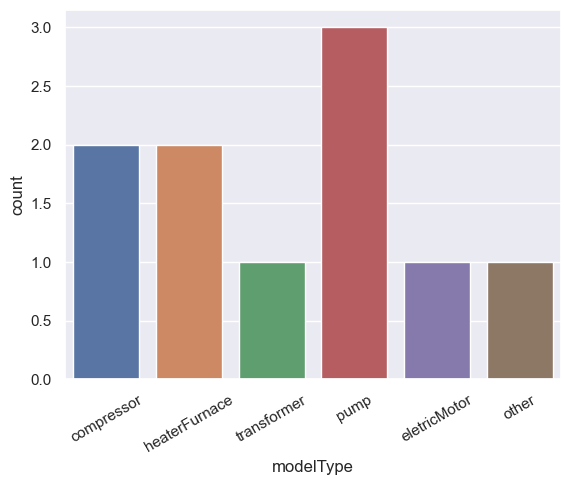

In [5]:
# plot from asset
ax=sns.countplot(data=DF_asset_clean,x="modelType")
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

[Text(0, 0, 'vertical'), Text(1, 0, 'axial'), Text(2, 0, 'horizontal')]

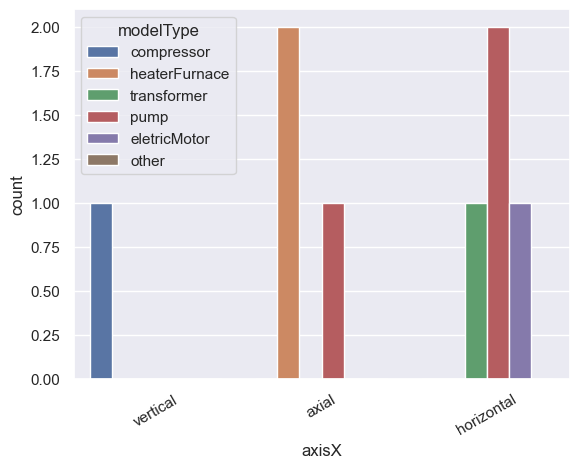

In [6]:
# plot from asset
ax=sns.countplot(data=DF_asset_clean,x="axisX",hue="modelType")
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

[Text(0, 0, 'horizontal'),
 Text(1, 0, 'vertical'),
 Text(2, 0, 'axial'),
 Text(3, 0, 'radial')]

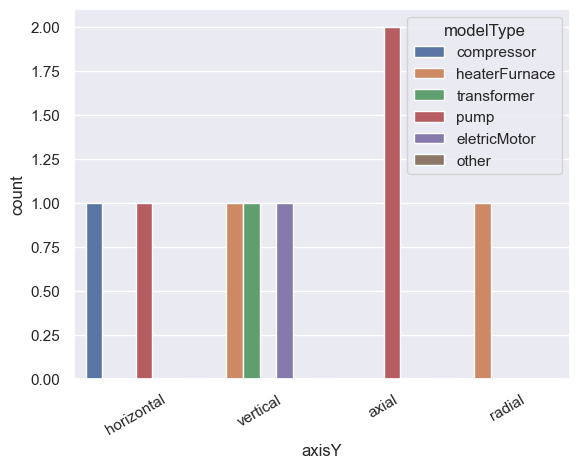

In [7]:
# plot from asset
ax=sns.countplot(data=DF_asset_clean,x="axisY",hue="modelType")
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

[Text(0, 0, 'axial'),
 Text(1, 0, 'horizontal'),
 Text(2, 0, 'vertical'),
 Text(3, 0, 'radial')]

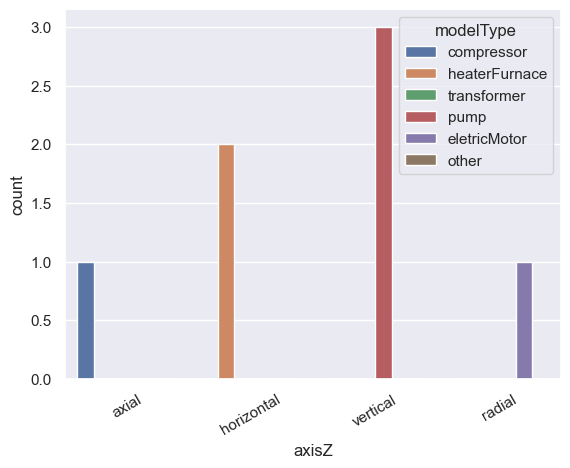

In [8]:
# plot from asset
ax=sns.countplot(data=DF_asset_clean,x="axisZ",hue="modelType")
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

C:\Users\Leonardo\AppData\Local\Temp\ipykernel_9528\2573126222.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=30)


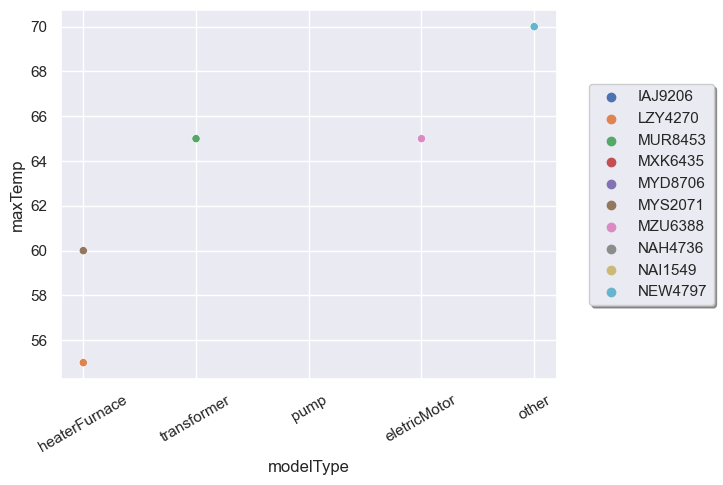

In [9]:
ax=sns.scatterplot(data=DF_asset_clean,x="modelType",y="maxTemp",hue="sensors")
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
          ncol=1, fancybox=True, shadow=True)

C:\Users\Leonardo\AppData\Local\Temp\ipykernel_9528\873144598.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=30)


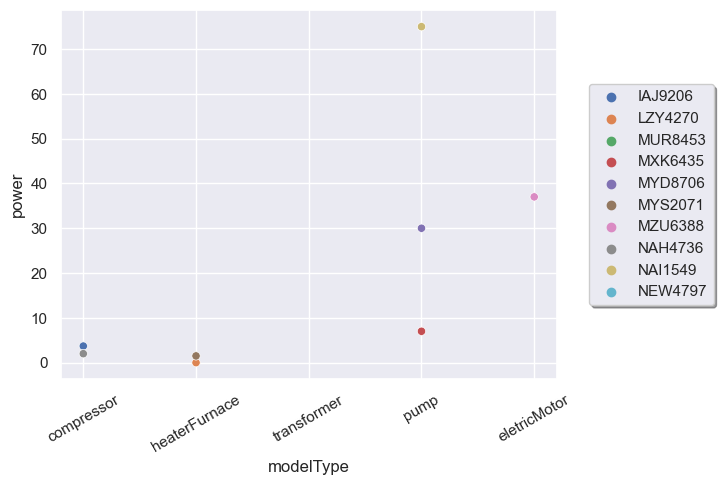

In [10]:
ax=sns.scatterplot(data=DF_asset_clean,x="modelType",y="power",hue="sensors")
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
          ncol=1, fancybox=True, shadow=True)

C:\Users\Leonardo\AppData\Local\Temp\ipykernel_9528\1590403037.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=30)


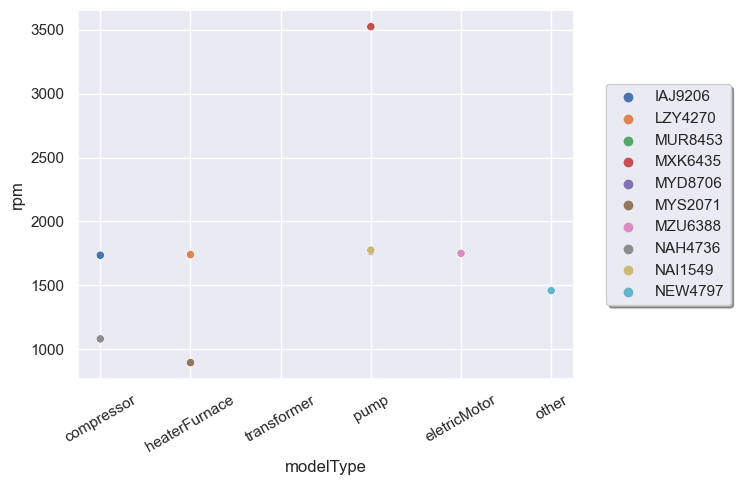

In [11]:

ax=sns.scatterplot(data=DF_asset_clean,x="modelType",y="rpm",hue="sensors")
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
          ncol=1, fancybox=True, shadow=True)

C:\Users\Leonardo\AppData\Local\Temp\ipykernel_9528\3290737870.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=30)


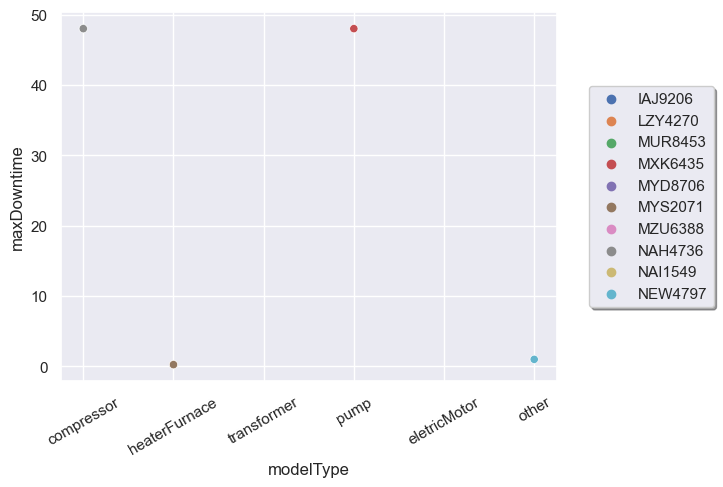

In [12]:
ax=sns.scatterplot(data=DF_asset_clean,x="modelType",y="maxDowntime",hue="sensors")
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
          ncol=1, fancybox=True, shadow=True)

In [13]:
DF_collects_clean["sensorId"].unique()

array(['IAJ9206', 'LZY4270', 'MUR8453', 'MXK6435', 'MYD8706', 'MYS2071',
       'MZU6388', 'NAH4736', 'NAI1549', 'NEW4797'], dtype=object)

Text(0.5, 1.0, 'MUR8453 Temperature')

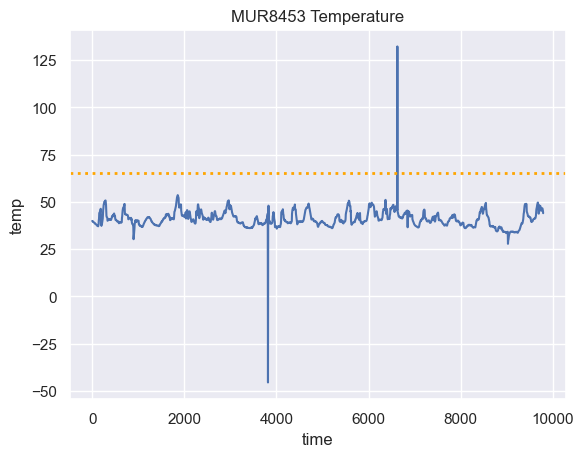

In [14]:
sensor = "MUR8453"
ax = sns.lineplot(data=DF_collects_clean[DF_collects_clean["sensorId"]==sensor],x="time",y="temp")
ax.axhline(y=int(DF_asset_clean.loc[DF_asset_clean["sensors"]==sensor,"maxTemp"]), linewidth=2, color='orange', ls=':')
ax.set_title(sensor + " Temperature")

Text(0.5, 1.0, 'MUR8453 Velocity in x')

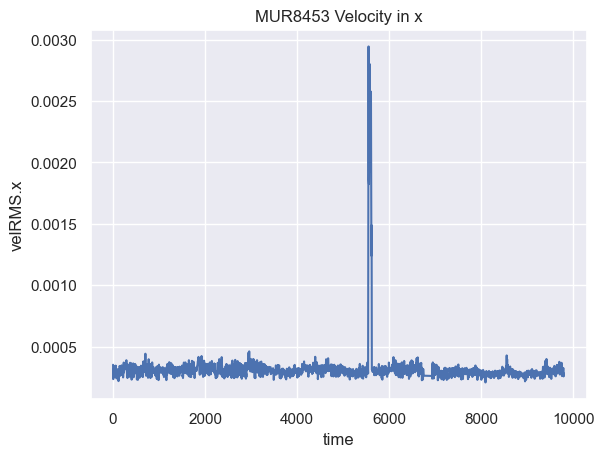

In [15]:
ax =sns.lineplot(data=DF_collects_clean[DF_collects_clean["sensorId"]==sensor],x="time",y="velRMS.x")
ax.set_title(sensor + " Velocity in x")
#ax.axhline(y=0.0003, linewidth=2, color='orange', ls=':')

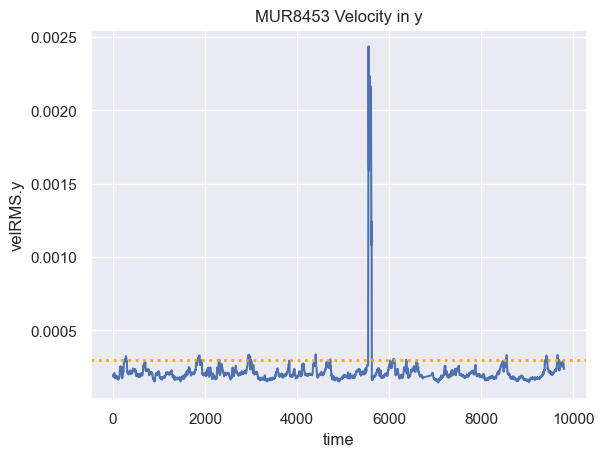

In [16]:
ax=sns.lineplot(data=DF_collects_clean[DF_collects_clean["sensorId"]==sensor],x="time",y="velRMS.y")
ax.set_title(sensor + " Velocity in y")
ax.axhline(y=0.0003, linewidth=2, color='orange', ls=':')

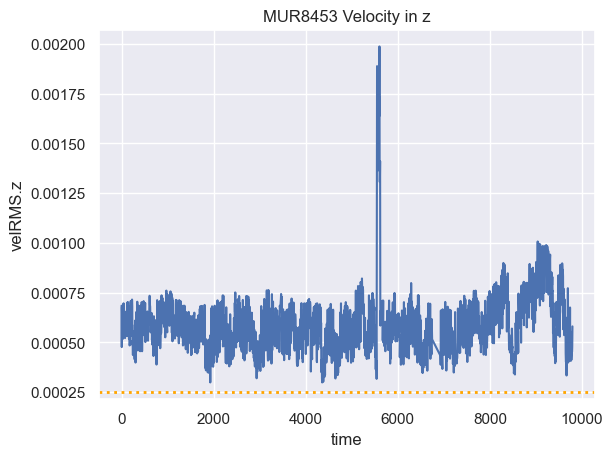

In [17]:
ax=sns.lineplot(data=DF_collects_clean[DF_collects_clean["sensorId"]==sensor],x="time",y="velRMS.z")
ax.set_title(sensor + " Velocity in z")
ax.axhline(y=0.00025, linewidth=2, color='orange', ls=':')

Text(0.5, 1.0, 'MUR8453 Acceleration in x')

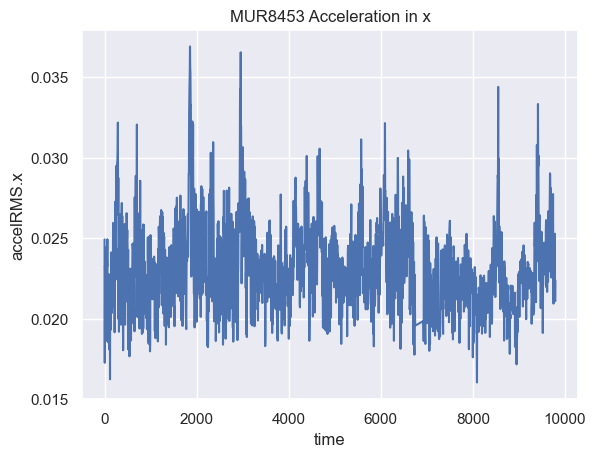

In [18]:
ax=sns.lineplot(data=DF_collects_clean[DF_collects_clean["sensorId"]==sensor],x="time",y="accelRMS.x")
ax.set_title(sensor + " Acceleration in x")

Text(0.5, 1.0, 'MUR8453 Acceleration in y')

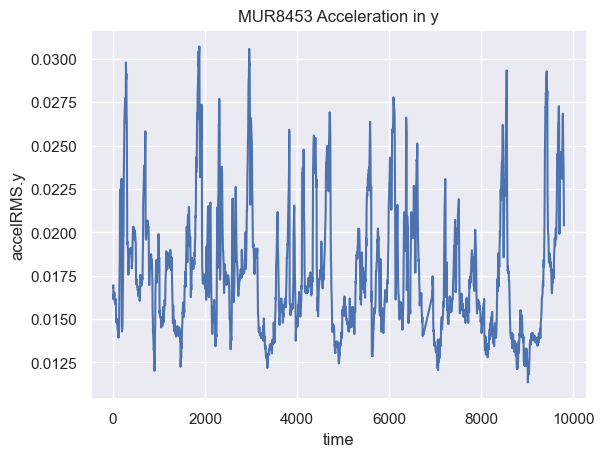

In [19]:
ax=sns.lineplot(data=DF_collects_clean[DF_collects_clean["sensorId"]==sensor],x="time",y="accelRMS.y")
ax.set_title(sensor + " Acceleration in y")

Text(0.5, 1.0, 'MUR8453 Acceleration in x')

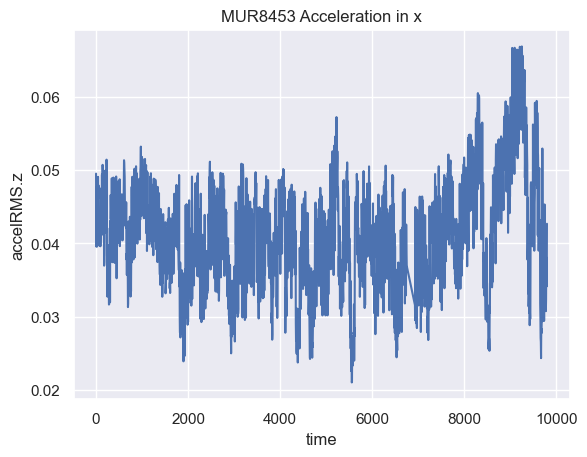

In [20]:
ax=sns.lineplot(data=DF_collects_clean[DF_collects_clean["sensorId"]==sensor],x="time",y="accelRMS.z")
ax.set_title(sensor + " Acceleration in x")

##  QUESTION 2

In [21]:
## 2 Downtime and uptime
# idea -> using the vibration data from all three axis whenever the accelaration is ~0  in all three axis 
# we consider that the machine is down. Summing the "duration" of each period of time when the machine is down, we will 
# be able to acquire the total downtime, and by consequence the uptime too.

# For this question I will use the asset "IAJ9206"



In [22]:
DF_Q2 = DF_collects_clean.loc[DF_collects_clean["sensorId"]=="IAJ9206"].copy()

In [23]:
# the function here solely compare all three velocity value for each coordanate, if all three are below a threshold,
# we consider that the machine is down 
# i created the function with this structure instead of directly analysing the dataframe at once because this makes more sense
# due to the fact that we do not have all the information at once, we need to analyse step-by-step

def downtime_q(x,y,z,trh=0.0003,duration=3.006):
    if (x < trh) & (y < trh) & (z < trh):
        time = duration
    else:
        time = 0
    return time



In [24]:
# mockup data acquisition in time
downtime=0
total_time =0
for i in range(DF_Q2.shape[0]):
    x=DF_Q2["velRMS.x"].iloc[i]
    y=DF_Q2["velRMS.y"].iloc[i]
    z=DF_Q2["velRMS.z"].iloc[i]
    time=downtime_q(x,y,z,trh=0.0002,duration=3.006)
    downtime = downtime + time
    total_time = total_time + 3.006

print("Downtime " + str(downtime) + " seconds")
print("Uptime " + str(total_time-downtime) + " seconds")
if downtime/60 < 48:
    print("Downtime below maximum downtime allowed!")
else: 
    print("Downtime above maximum downtime allowed!!!!!!!!!!")

Downtime 1764.5220000000138 seconds
Uptime 10217.393999999586 seconds
Downtime below maximum downtime allowed!


## QUESTION 3

In [25]:
# For this task a possible way to analyzing the vibration signals is to "cut the signal" into observation windows
# and apply fft and compare the harmonic components for each observation window, and whenever there is a "relevant"
# difference we will consider that there is a change in the system behavior.
# this type of analysis can help us understand the different type loads that the system is subject





In [26]:
DF_Q3 = DF_collects_clean.loc[DF_collects_clean["sensorId"]=="MZU6388"].copy()
#removing a single NaN measurement.
DF_Q3.dropna(inplace=True)
DF_Q3["obs_win"]=pd.qcut(DF_Q3["time"], 20,labels=False)
a,ret=pd.qcut(DF_Q3["time"],20, labels=False,retbins=True)

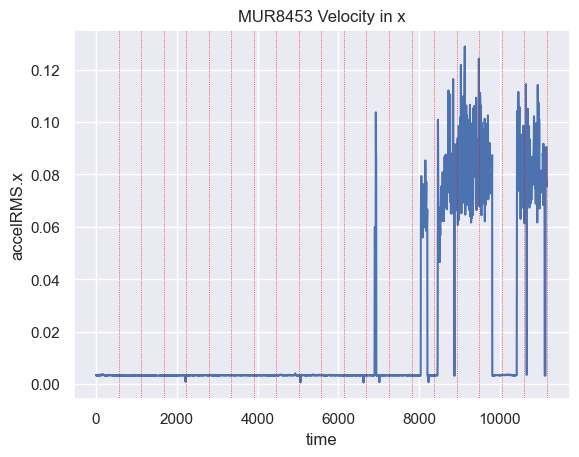

In [27]:
ax=sns.lineplot(data=DF_collects_clean[DF_collects_clean["sensorId"]=="MZU6388"],x="time",y="accelRMS.x")
ax.set_title(sensor + " Velocity in x")
for  i in range(1,len(ret),1):   
    ax.axvline(x=ret[i], linewidth=0.5, color='red', ls=':')

C:\ProgramData\anaconda3\Lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


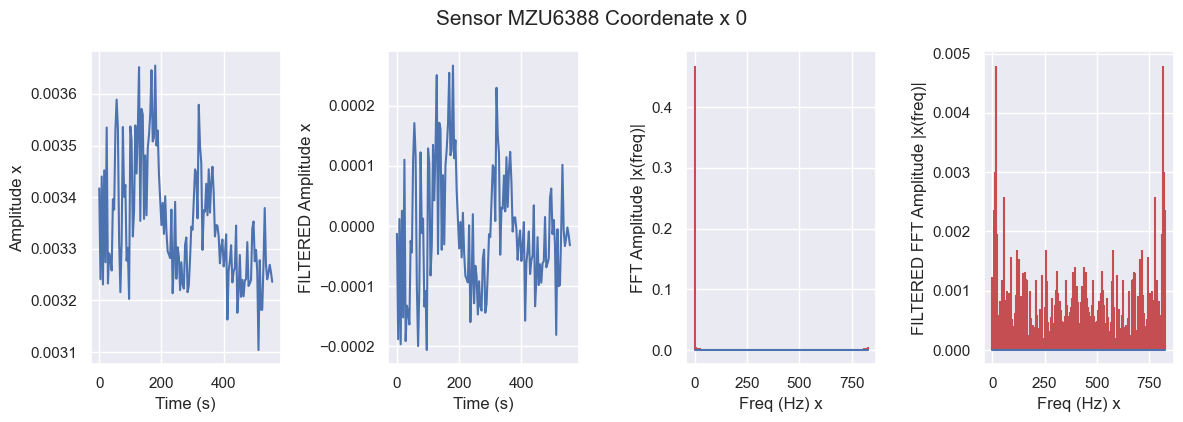

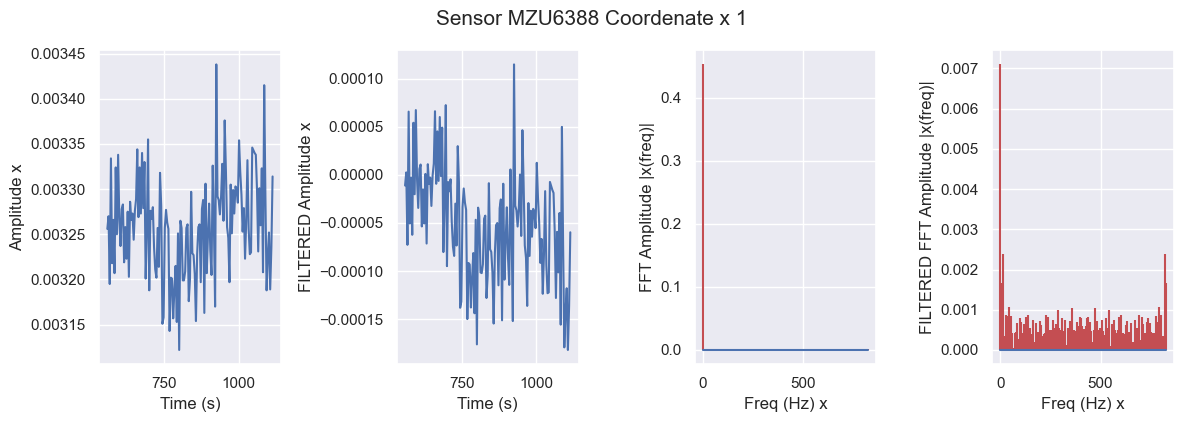

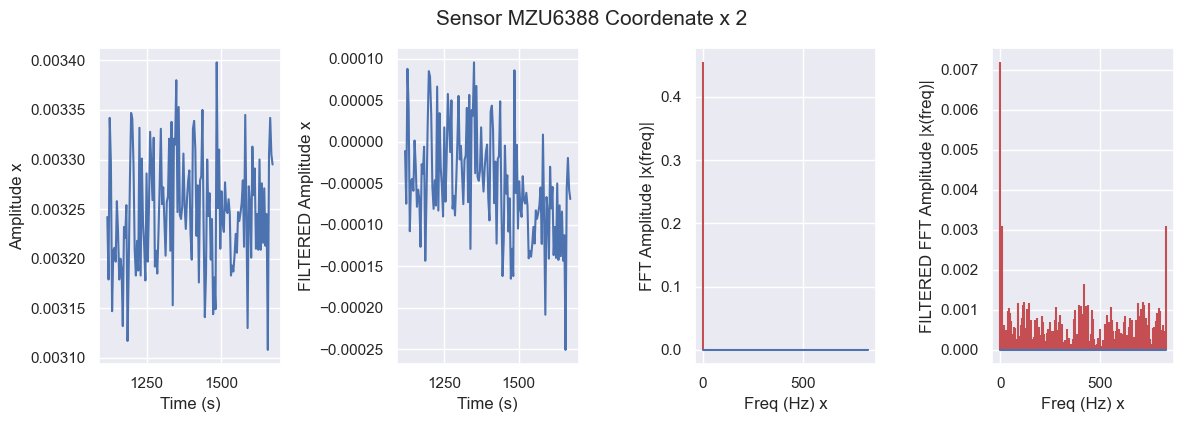

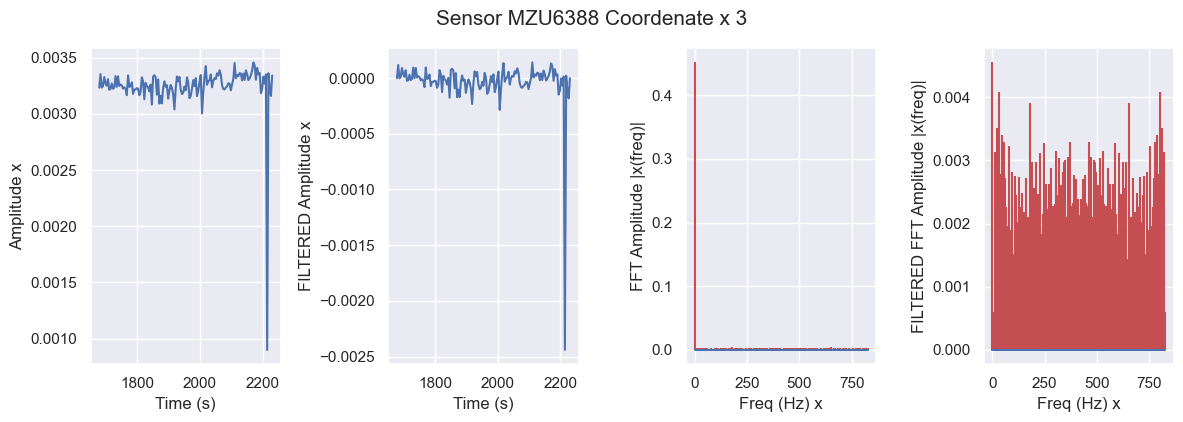

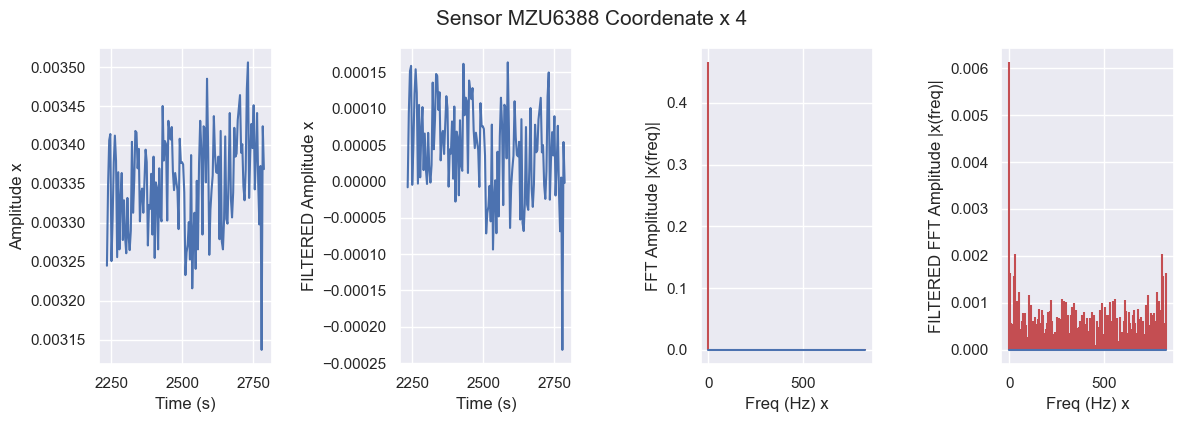

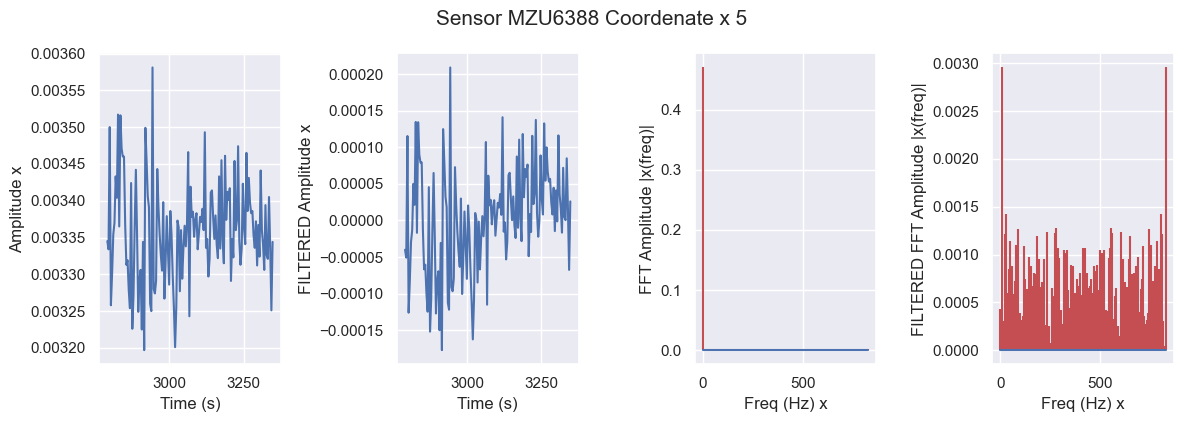

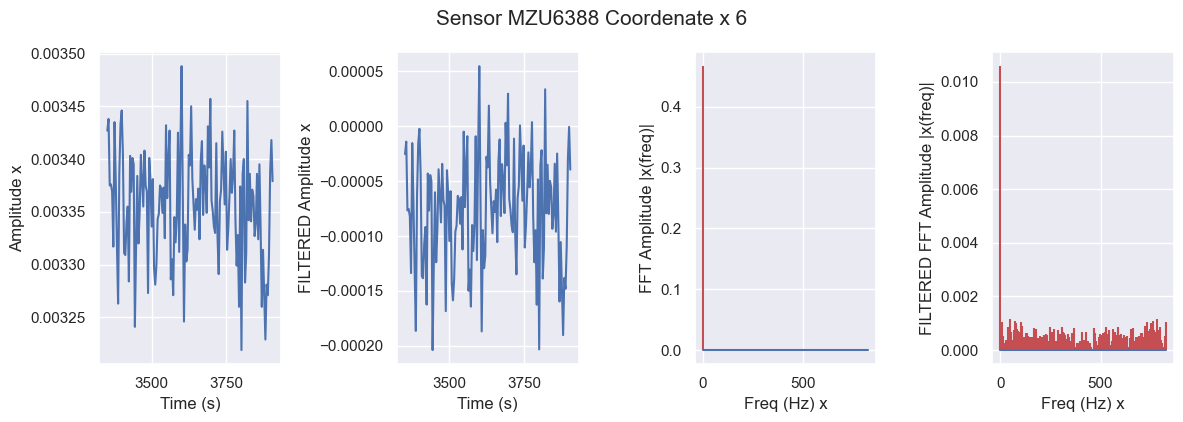

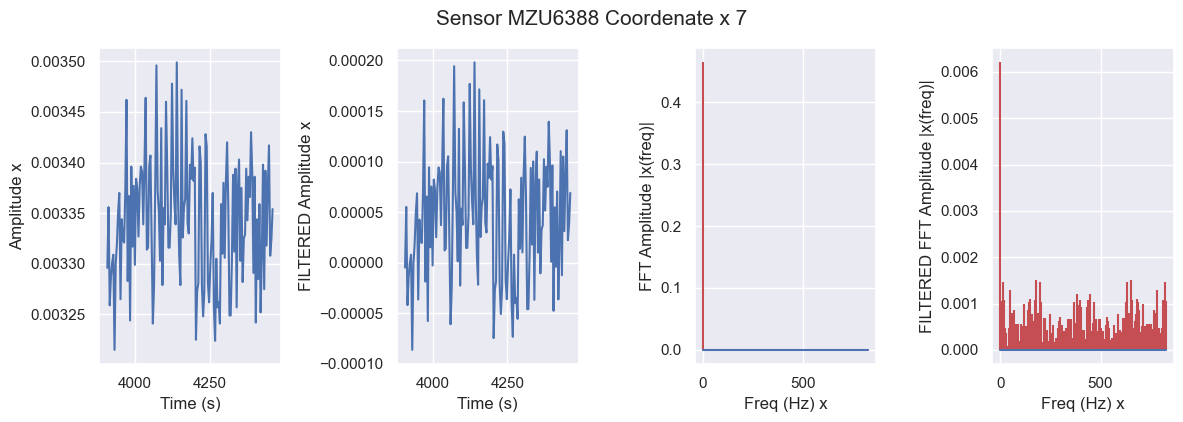

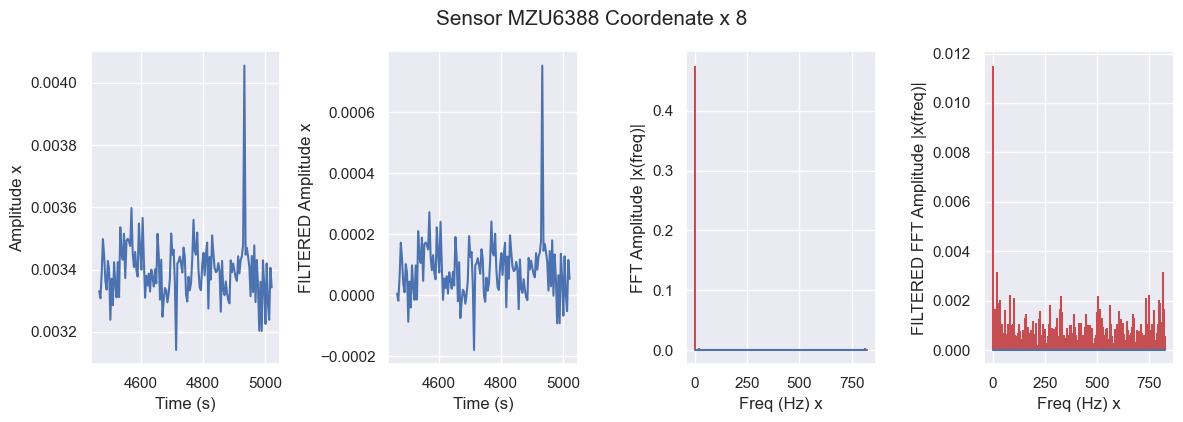

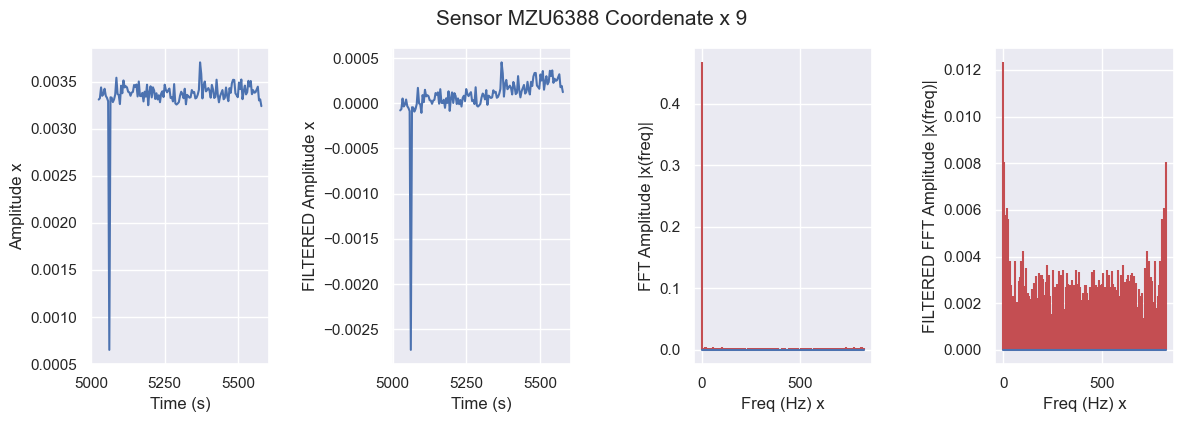

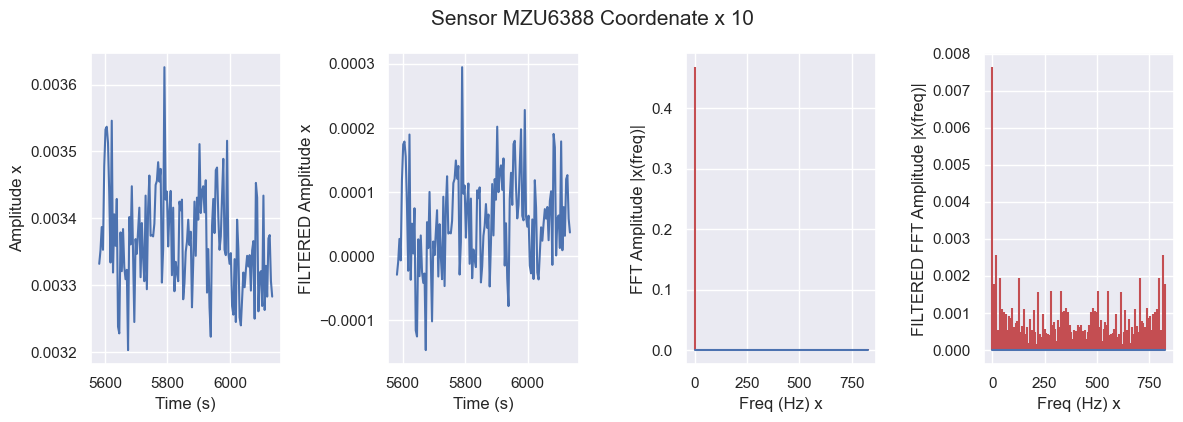

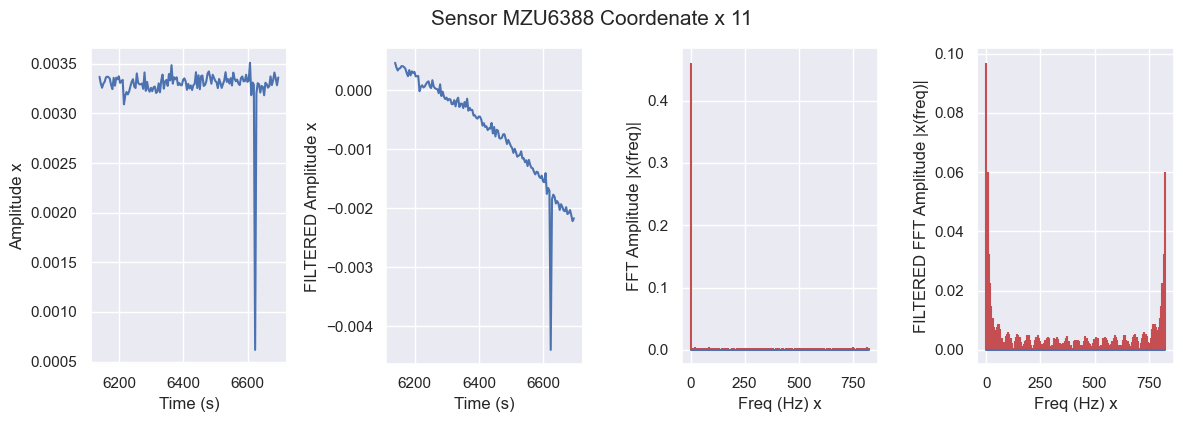

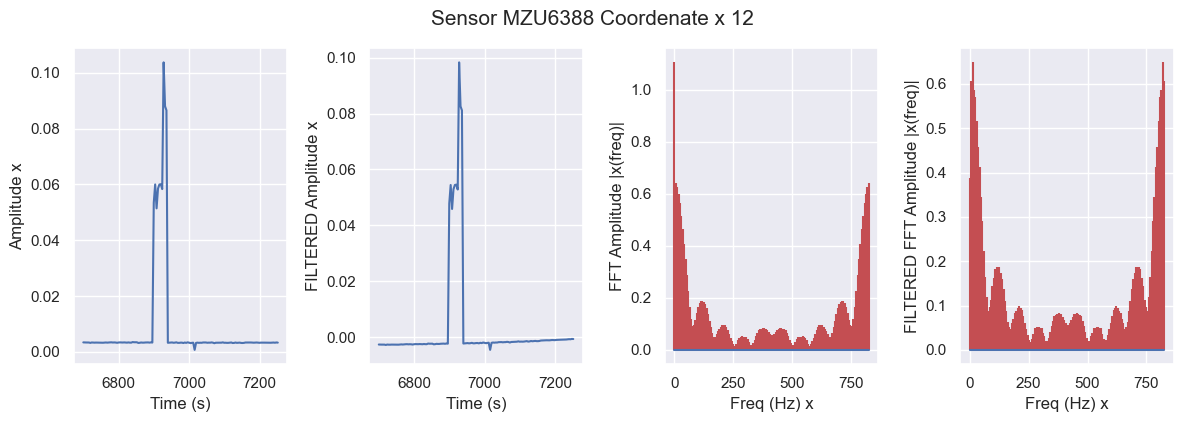

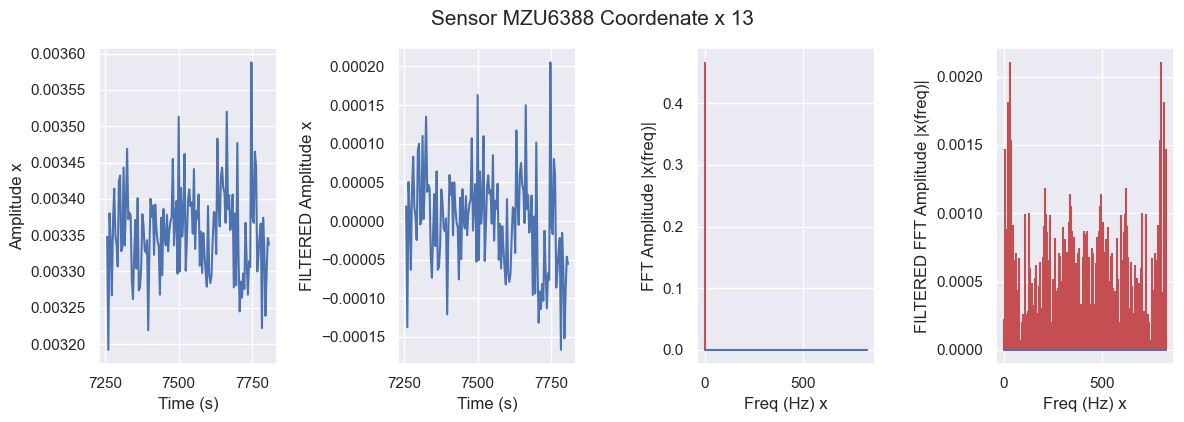

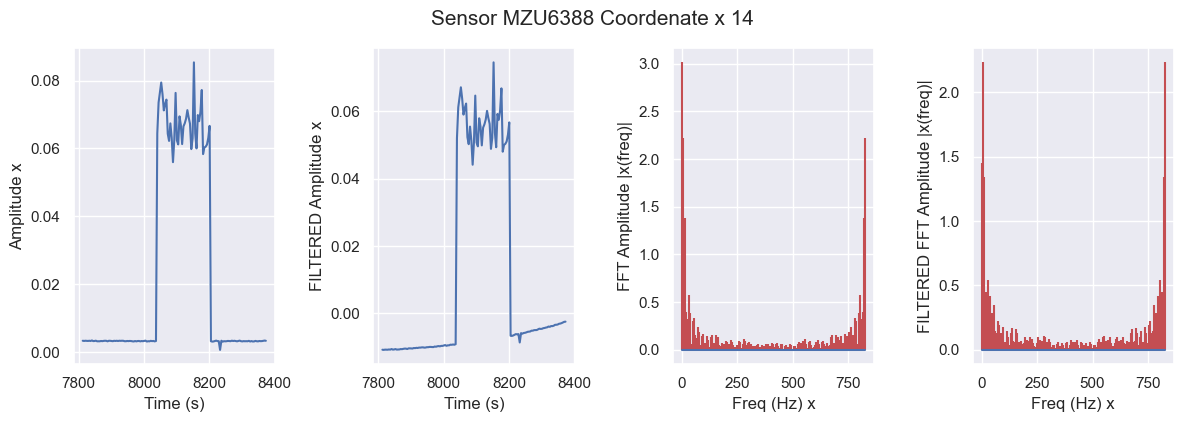

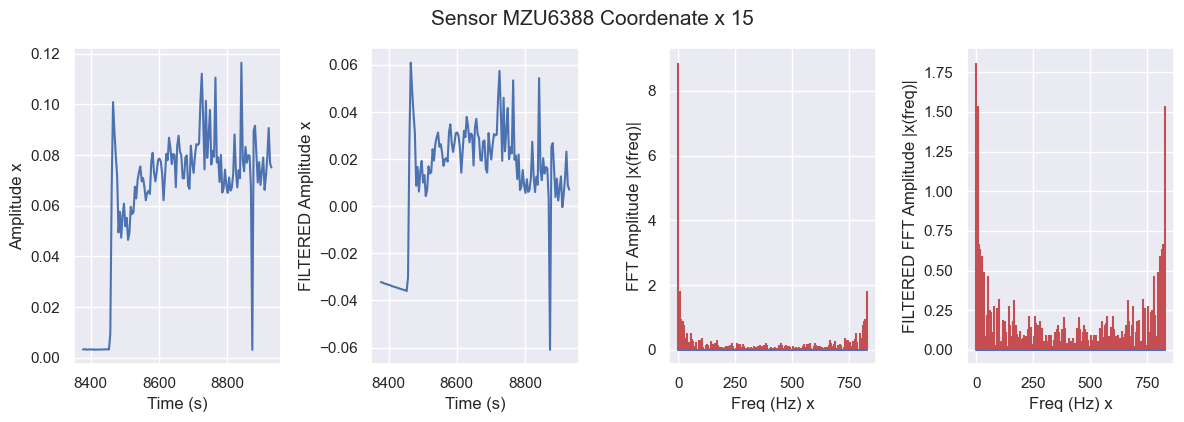

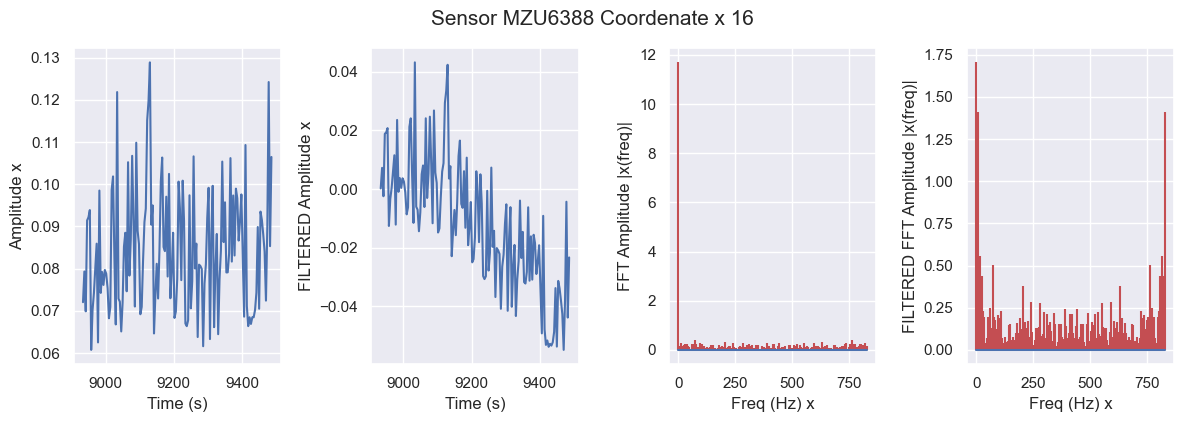

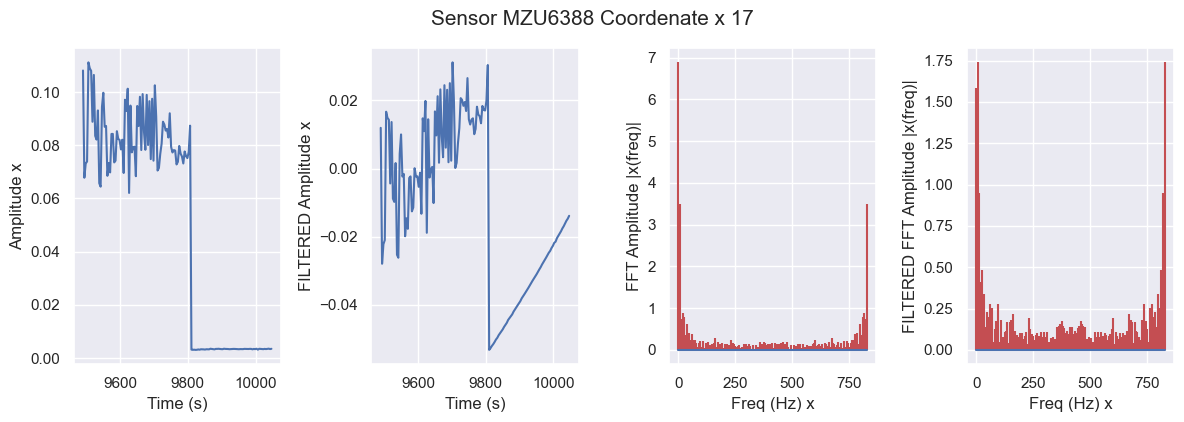

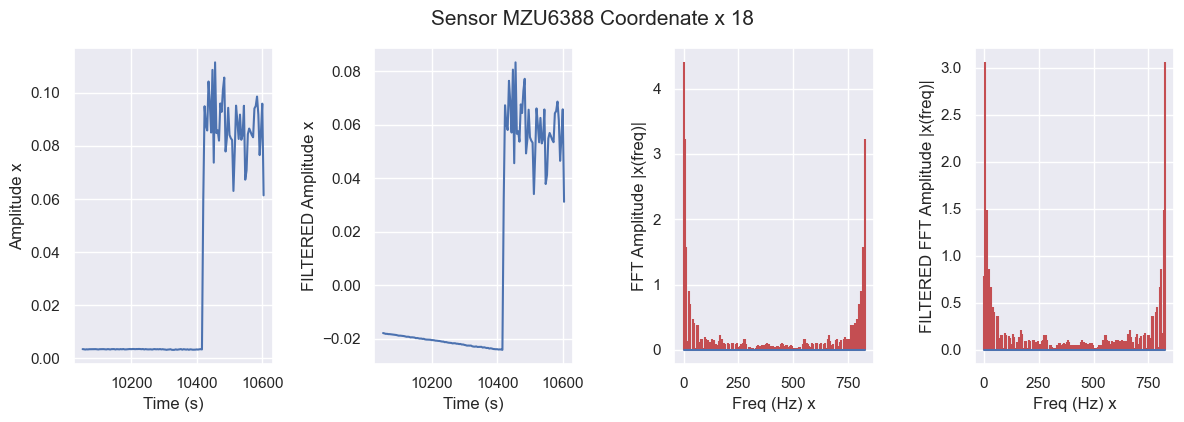

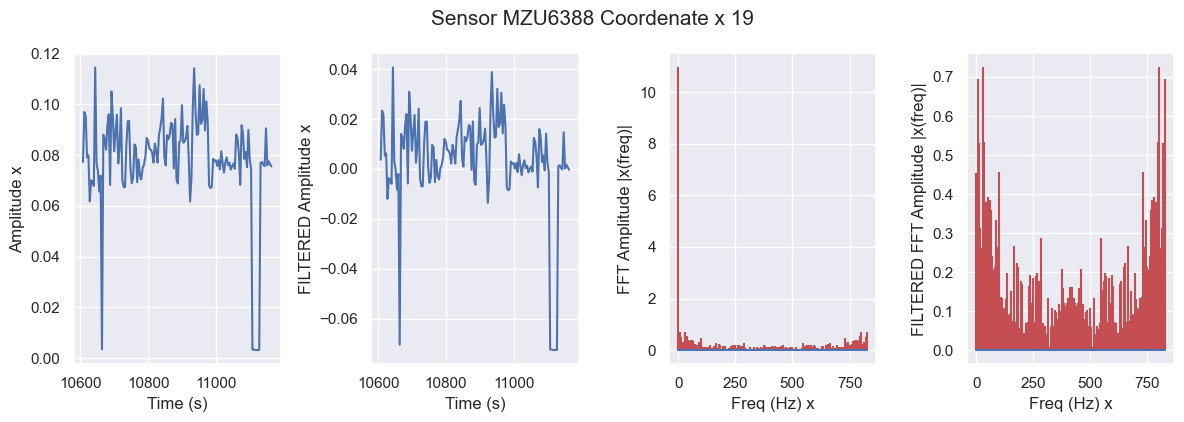

In [28]:
obs_win = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
for i in obs_win:
    x = DF_Q3.loc[DF_Q3["obs_win"]==obs_win[i],"accelRMS.x"]
    X = fft(x)
    N = len(X)
    t = DF_Q3.loc[DF_Q3["obs_win"]==obs_win[i],"time"]
    sr = DF_Q3.loc[DF_Q3["obs_win"]==obs_win[i],"sampRate"].iloc[0]
    n = np.arange(N)
    T = N/sr
    freq = n/T 

    cutoff =0.5
    # FILTERED HIGH-PASS
    sos = scipy.signal.butter(5, cutoff, 'highpass', fs=sr, output='sos')
    x_filtered = scipy.signal.sosfiltfilt(sos, x)
    X_filtered = fft(x_filtered)



    plt.figure(figsize = (12, 4))

    plt.subplot(141)
    plt.plot(t, ifft(X), "b")
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude '+ "x")

    plt.subplot(142)
    plt.plot(t, ifft(X_filtered), "b")
    plt.xlabel('Time (s)')
    plt.ylabel('FILTERED Amplitude '+ "x")

    plt.subplot(143)
    plt.stem(freq, np.abs(X), "r", \
             markerfmt=" ", basefmt="-b")
    plt.xlabel('Freq (Hz) ' + "x")
    plt.ylabel('FFT Amplitude |' + "x"+'(freq)|')
    #plt.xlim(-5, 100)

    plt.subplot(144)
    plt.stem(freq, np.abs(X_filtered), "r", \
             markerfmt=" ", basefmt="-b")
    plt.xlabel('Freq (Hz) ' + "x")
    plt.ylabel('FILTERED FFT Amplitude |' + "x"+'(freq)|')
    #plt.xlim(-5, 100)

    plt.tight_layout()
    plt.suptitle("Sensor "+DF_Q3.loc[DF_Q3["obs_win"]==0,"sensorId"].iloc[0]+" Coordenate "+ "x " + str(obs_win[i]), fontsize=15,x=0.5,y=1.05)
    plt.show()

In [29]:
# Now comparing the Filtered
compa_valu=[]
for i in obs_win:
    x = DF_Q3.loc[DF_Q3["obs_win"]==obs_win[i],"accelRMS.x"]
    sos = scipy.signal.butter(5, cutoff, 'highpass', fs=sr, output='sos')
    x_filtered = scipy.signal.sosfiltfilt(sos, x)
    X_filtered = fft(x_filtered)
    X_filtered_abs = np.abs(X_filtered)
    X_filtered_abs_mean = np.mean(X_filtered_abs)
    X_filtered_abs_std = np.std(X_filtered_abs)
    aux = X_filtered_abs_mean + X_filtered_abs_std
    #print(aux.round(7))
    compa_valu = np.append(compa_valu, aux)
    if i == 0:
        compa_fin=0
    else:
        compa_fin = np.abs(compa_valu[i]-compa_valu[i-1])/compa_valu[i-1]
        print(compa_fin.round(5))
        if compa_fin >= 3:
            print("!!!!!!!the system load changed!!!!!!!!!" +"observation window "+str(i) + " time " + str(ret[i].round(2)) + "ms") 

0.23032
0.06084
1.30405
0.592
0.10062
0.30051
0.16491
0.67356
1.06512
0.64581
10.14371
!!!!!!!the system load changed!!!!!!!!!observation window 11 time 6138.0ms
15.9578
!!!!!!!the system load changed!!!!!!!!!observation window 12 time 6696.0ms
0.99642
467.72683
!!!!!!!the system load changed!!!!!!!!!observation window 14 time 7812.0ms
0.08174
0.08543
0.05591
0.3863
0.43672


In [53]:
## creating the functions
## FUNCTION TO OBTAIN THE WINDOW VALUE
def var_on_obs_win(x,x_win,obs_win_size,duration):
    x_win = np.append(x_win,x)
    if len(x_win) == obs_win_size:
        sr = DF_Q3["sampRate"].iloc[0]
        sos = scipy.signal.butter(5, 0.5, 'highpass', fs=sr, output='sos')
        x_filtered = scipy.signal.sosfiltfilt(sos, x_win)
        X_filtered = fft(x_filtered)
        X_filtered_abs = np.abs(X_filtered)
        X_filtered_abs_mean = np.mean(X_filtered_abs)
        X_filtered_abs_std = np.std(X_filtered_abs)
        valu_on_window = X_filtered_abs_mean + X_filtered_abs_std
        x_win=[]
    else:
        valu_on_window = 0
    return x_win, valu_on_window

## FUNCTION TO COMPARE THE WINDOWS
def compa_win(valu_all,valu_on_window,thre,obs_win_size,duration):
    if len(valu_all) == 0:
        compa= 0
        valu_all = np.append(valu_all,valu_on_window)
    else:
        compa_1 = np.abs(valu_on_window-valu_all[-1])/valu_all[-1]
        compa_2 = np.abs(valu_on_window-valu_all[-1])/valu_on_window
        zscore_valu_ow = (valu_on_window - np.mean(valu_all)) / np.std(valu_all)
        print(str(zscore_valu_ow))
        valu_all = np.append(valu_all,valu_on_window)
        if (zscore_valu_ow >= 2): #| (compa_2 >= thre):
            print("!!!!!!!the system load changed!!!!!!!!!" +"observation window " + str(len(valu_all)+1) + " starting at " + str(obs_win_size*duration*(len(valu_all)-1)))
        else:
            print("the system load is the same")
    return valu_all


In [54]:
# mockup data acquisition in time
x_win = []
valu_all = []
for i in range(0,len(DF_Q3["accelRMS.x"]),1):
    x=DF_Q3["accelRMS.x"].iloc[i]
    x_win, valu_on_window=var_on_obs_win(x,x_win,140,4.003)
    if valu_on_window != 0:
        print(str(i)+" "+str(valu_on_window.round(6))+"!!!!!!!!!!!!!!!!!!!!!!!!")
        valu_all=compa_win(valu_all,valu_on_window,1.5,140,4.003)
    

139 0.001678!!!!!!!!!!!!!!!!!!!!!!!!
279 0.001244!!!!!!!!!!!!!!!!!!!!!!!!
-inf
the system load is the same
419 0.001481!!!!!!!!!!!!!!!!!!!!!!!!
0.0931823053607325
the system load is the same
559 0.00367!!!!!!!!!!!!!!!!!!!!!!!!
12.393906606426711
!!!!!!!the system load changed!!!!!!!!!observation window 5 starting at 1681.2600000000002
699 0.002075!!!!!!!!!!!!!!!!!!!!!!!!
0.05879613881155661
the system load is the same
839 0.001114!!!!!!!!!!!!!!!!!!!!!!!!
-1.0596274151095497
the system load is the same
979 0.001085!!!!!!!!!!!!!!!!!!!!!!!!
-0.921770832438256
the system load is the same
1119 0.00158!!!!!!!!!!!!!!!!!!!!!!!!
-0.21804596120803665
the system load is the same
1259 0.001805!!!!!!!!!!!!!!!!!!!!!!!!
0.08088113761448046
the system load is the same
1399 0.004185!!!!!!!!!!!!!!!!!!!!!!!!
3.269180727037607
!!!!!!!the system load changed!!!!!!!!!observation window 11 starting at 5043.780000000001
1539 0.002261!!!!!!!!!!!!!!!!!!!!!!!!
0.26435992884695875
the system load is the same
1679

C:\Users\Leonardo\AppData\Local\Temp\ipykernel_9528\1483634768.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  zscore_valu_ow = (valu_on_window - np.mean(valu_all)) / np.std(valu_all)


In [52]:
event = [1681,5043,6164,6725,7845,8406,10087]

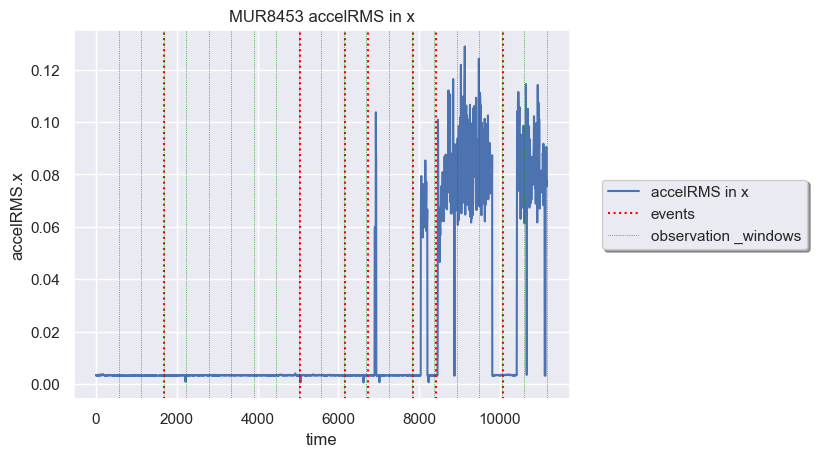

In [45]:
my_labels = {"x1" : "events", "x2" : "observation _windows"}
ax=sns.lineplot(data=DF_collects_clean[DF_collects_clean["sensorId"]=="MZU6388"],x="time",y="accelRMS.x",label='accelRMS in x')
ax.set_title(sensor + " accelRMS in x")
#event = [6725,7285,7845]
for j in range(0,len(event),1):
    ax.axvline(x=event[j], linewidth=1.5, color='red', ls=':',label=my_labels["x1"])
    my_labels["x1"] = "_nolegend_"
for  i in range(1,len(ret),1):   
    ax.axvline(x=ret[i], linewidth=0.5, color='green', ls=':',label=my_labels["x2"])  
    my_labels["x2"] = "_nolegend_"
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
          ncol=1, fancybox=True, shadow=True)

## QUESTION 4

In [ ]:
# I will use xgboost to do a time series forecasting, then calculate the residue signal x - xhat, after that use 
# an evaluation function and compare the acquired signal with some criteria to consider if this a fault 
# or a regular change of load
# besides the forecasting, some parameter do not need this intricate solution, such as temperature and rpm, if those 
# parameters surpasses an predeterminated threshold we will consider that is a fault.
# and the third situation that sshould be accounted for is the sensor fault which is caracterized by NaN value of the measurement

In [56]:
DF_collects_clean.columns

Index(['sensorId', 'accelRMS.x', 'accelRMS.y', 'accelRMS.z', 'duration',
       'sampRate', 'timeStart', 'velRMS.x', 'velRMS.y', 'velRMS.z', 'temp',
       'time'],
      dtype='object')

In [157]:
#sensor="MUR8453"
#sensor="MYD8706" #best so far
#sensor="NAI1549" #another one that is good 
# both are skipping one change of load
sensor="NEW4797" 

Text(0.5, 1.0, 'NEW4797 Acceleration in z')

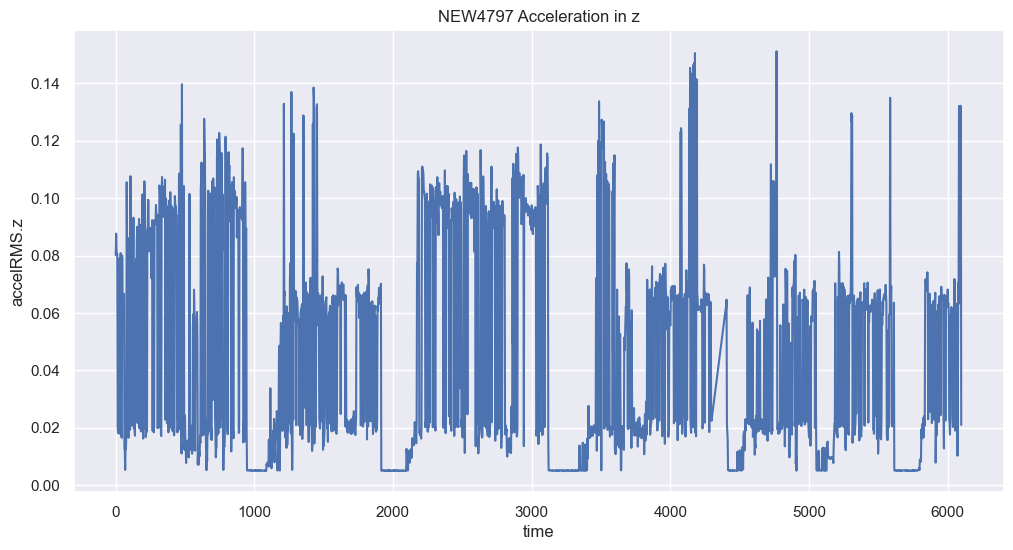

In [158]:
plt.figure(figsize=(12, 6))
ax=sns.lineplot(data=DF_collects_clean[DF_collects_clean["sensorId"]==sensor],x="time",y="accelRMS.z")
ax.set_title(sensor + " Acceleration in z")

Text(0.5, 1.0, 'NEW4797 temp')

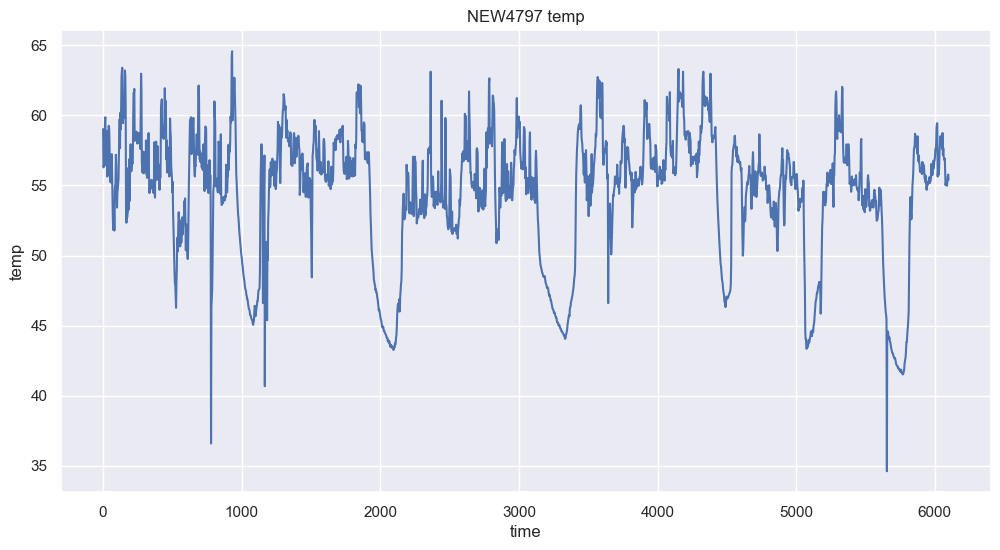

In [159]:
plt.figure(figsize=(12, 6))
ax=sns.lineplot(data=DF_collects_clean[DF_collects_clean["sensorId"]==sensor],x="time",y="temp")
ax.set_title(sensor + " temp")

In [137]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

#plt.style.use('fivethirtyeight')



In [160]:
#USING THE SENSOR MYD8706
#sensor="MYD8706"
DF_Q4 = DF_collects_clean[DF_collects_clean["sensorId"]==sensor].copy()
#getting only the necessary features
DF_Q4_slim = DF_Q4[["accelRMS.z", "temp", "time"]].copy()

In [166]:
# Separeting the data into train test ad validation
DF_Q4_slim_train = DF_Q4_slim.loc[DF_Q4_slim["time"] <= 1500].copy()
DF_Q4_slim_test = DF_Q4_slim.loc[(DF_Q4_slim["time"] > 1500)&(DF_Q4_slim["time"] <= 3000)].copy()
DF_Q4_slim_validation = DF_Q4_slim.loc[DF_Q4_slim["time"]> 3000].copy()

In [219]:
# Separating the data into input and output
y_train = DF_Q4_slim_train["accelRMS.z"].copy()
X_train = DF_Q4_slim_train[["temp","time"]].copy()

y_test = DF_Q4_slim_test["accelRMS.z"].copy()
X_test = DF_Q4_slim_test[["temp","time"]].copy()

y_validation = DF_Q4_slim_validation["accelRMS.z"].copy()
X_validation = DF_Q4_slim_validation[["temp","time"]].copy()

In [220]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

In [307]:
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1, 0.2, 0.4, 0.7],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror','reg:squaredlogerror','reg:absoluteerror']
    }

    xgb_model = xgb.XGBRegressor()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)
    return gsearch.best_params_

In [264]:
hyperParameterTuning(X_train, y_train)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


{'colsample_bytree': 0.5,
 'learning_rate': 0.01,
 'max_depth': 3,
 'min_child_weight': 3,
 'n_estimators': 500,
 'objective': 'reg:squaredlogerror',
 'subsample': 0.5}

In [313]:
xgb_model = xgb.XGBRegressor(
        objective = 'reg:absoluteerror',
        colsample_bytree = 0.5,
        learning_rate = 0.4,
        max_depth = 9,
        min_child_weight = 5,
        n_estimators = 500,
        subsample = 0.5)

%time xgb_model.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_test, y_test)], verbose=False)

y_pred_xgb = xgb_model.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print("MAE: ", mae_xgb)
print("MSE: ", mse_xgb)


CPU times: total: 156 ms
Wall time: 14 ms
MAE:  0.03118799105901938
MSE:  0.0014472924778285825


C:\ProgramData\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [314]:
# validating the model with a naive data
y_validation_xgb = xgb_model.predict(X_validation)

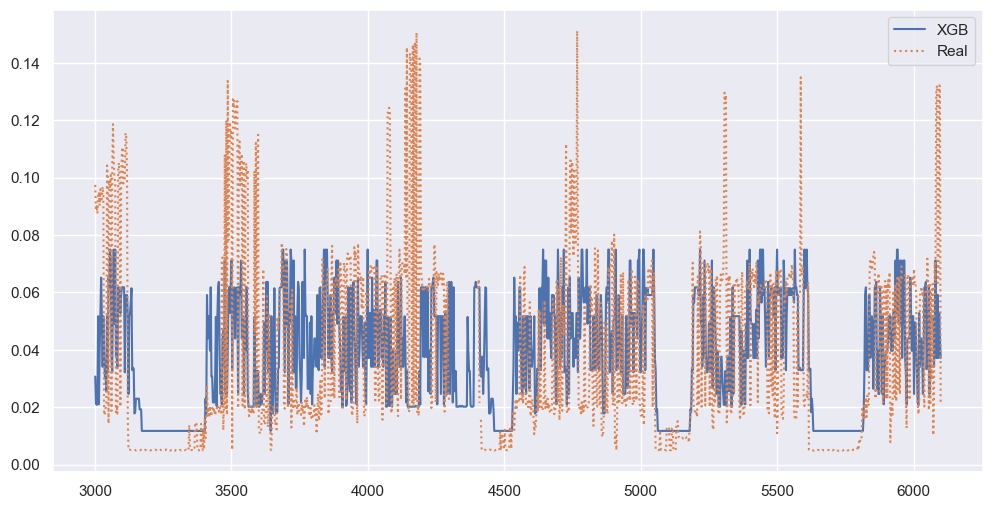

In [315]:
#ploting the real validation values and the values acquired with xgboost
plt.figure(figsize=(12, 6))
plt.plot(X_validation["time"], y_validation_xgb, label = "XGB",linestyle='-') 
plt.plot(X_validation["time"], y_validation, label = "Real",linestyle=':') 
plt.legend() 
plt.show()

In [422]:
resi =  y_validation -y_validation_xgb

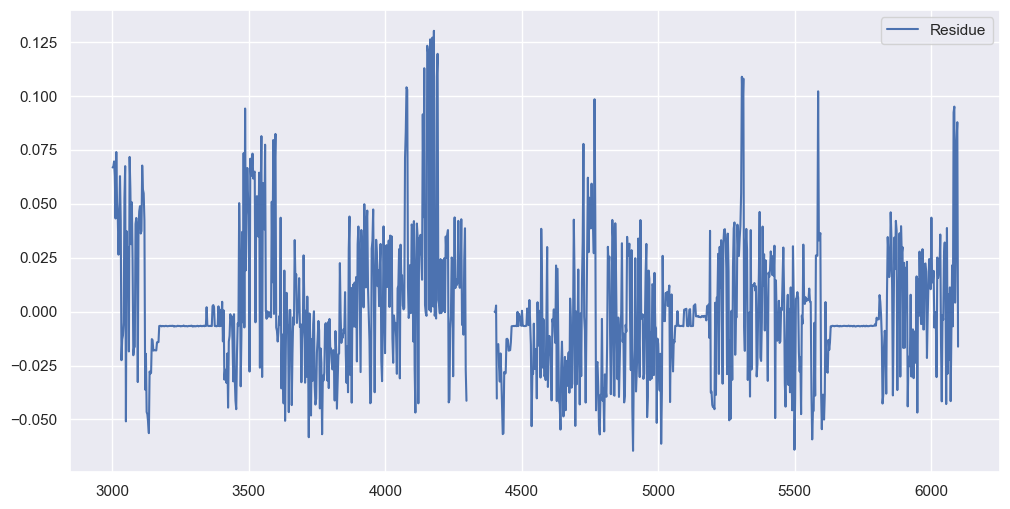

In [423]:
# residuel value plot
plt.figure(figsize=(12, 6))
plt.plot(X_validation["time"], resi, label = "Residue",linestyle='-') 
plt.legend() 
plt.show()

In [417]:
def fault_detection(xgb_model,thre,input_data,temp_thre,resi_count,sen_fault):
    if input_data["temp"][0]>= temp_thre:
        print("!!!!!!!Fault Detected the equipment is overheating!!!!!!!!")
    if math.isnan(input_data["accelRMS.z"]):
        sen_fault += 1
        if sen_fault > 20:
            print("!!!!!!!The sensor is not working properly!!!!!!!!")
    yhat = xgb_model.predict(input_data[["temp","time"]])
    resi = float(input_data["accelRMS.z"]-yhat)
    print(str(resi))
    if resi >=thre:
        resi_count += 1
        if resi_count > 5:
            print("!!!!!!!The equipment needs attention, fault might occur !!!!!!!!")
    return resi_count,sen_fault,resi

In [419]:
# mockup data acquisition in time
resi_count = 0
sen_fault = 0
resi_plot =[]
for i in range(0,DF_Q4_slim_validation.shape[0],1):
    print(i)
    d = {'accelRMS.z': [DF_Q4_slim_validation.iloc[i][0]]
     , 'temp': [DF_Q4_slim_validation.iloc[i][1]]
     , 'time': [DF_Q4_slim_validation.iloc[i][2]]}
    dataframe_nano = pd.DataFrame(data=d)
    resi_count,sen_fault,resi_aux=fault_detection(xgb_model,0.15,dataframe_nano,70.0,resi_count,sen_fault)
    resi_plot = np.append(resi_plot,resi_aux)

0
0.06681488084864616
1
0.06709027931094169
2
0.06960212005352974
3
0.06284952114582061
4
0.04315732041144371
5
0.07396228003895283
6
0.050622122963190075
7
0.044289320411443706
8
0.02640168018817901
9
0.04103532041144371
10
0.06277352010321617
11
0.04203032041144371
12
-0.02251235899066925
13
-0.012825119151353835
14
-0.011020119151353838
15
-0.005027959208607675
16
0.052546320411443706
17
0.06742372194933892
18
-0.05087031981182098
19
0.037277242516040796
20
0.021765075314998633
21
0.02981347846221924
22
-0.01847112216758728
23
0.07168472194933892
24
0.0568912425160408
25
0.031229075314998633
26
0.05066887791728973
27
0.023752075314998622
28
-0.020218957100868226
29
-0.01673495858836174
30
-0.01628447989678383
31
0.04059124251604081
32
0.043405242516040804
33
0.039973439816474915
34
-0.03264548202037811
35
0.03866443981647491
36
0.0465202425160408
37
0.048860242516040805
38
0.0361872425160408
39
0.0373662425160408
40
0.06769572194933891
41
0.05652043981647492
42
0.05484343981647491
4

0.040387521145820615
405
0.03875552114582062
406
-0.013843358990669252
407
0.04194452114582062
408
-0.02642167958855629
409
-0.04677916091251373
410
0.02217571928358078
411
0.04082652010321618
412
0.034736520103216165
413
-0.04250731981182099
414
0.03417452010321617
415
0.026552719283580786
416
0.03558952010321617
417
0.025459719283580776
418
0.014782320411443714
419
0.09143364100933074
420
0.043795279310941695
421
0.11280323779606818
422
0.0030845187239646916
423
-0.0005554812760353092
424
-0.0019514812760353072
425
0.1232005187239647
426
0.1205065187239647
427
0.12018051872396468
428
0.0007435187239646923
429
0.1261945187239647
430
-6.94812760353089e-05
431
0.1250505187239647
432
0.1269885187239647
433
0.00238611966896057
434
0.13014011966896058
435
-0.0018484812760353082
436
-0.00034848127603531037
437
-0.0032024812760353093
438
0.10891423779606818
439
0.119471919298172
440
0.005389637396812433
441
0.0033596373968124427
442
-0.0007963626031875642
443
0.024351042899131772
444
-0.0006

-0.0432217574839592
811
-0.0442737574839592
812
-0.0437307574839592
813
-0.045222757483959194
814
0.004125561121463769
815
-0.03859356018352508
816
0.006473439816474913
817
0.006309075314998622
818
0.02678287791728974
819
-0.028886122082710266
820
0.030013520103216174
821
0.01106387741303444
822
0.033089877832412726
823
-0.0036855215377807615
824
-0.03339688297367096
825
0.031496877832412715
826
0.03791172194933891
827
0.03820372194933891
828
0.03362952010321617
829
0.020063877917289738
830
-0.028984122082710267
831
0.03613872194933891
832
0.018481877917289738
833
-0.05037252153778076
834
-0.013508479787945747
835
-0.0496727574839592
836
0.0003865611214637771
837
-0.031606482020378114
838
0.020687719283580777
839
0.038569521145820615
840
0.041317521145820615
841
-0.02000367986559868
842
-0.002352481276035309
843
-0.0026554812760353104
844
0.040293518723964694
845
0.028791041411638255
846
0.025783042899131775
847
0.03387988084864617
848
0.039594040791392324
849
0.054832919298171995
850


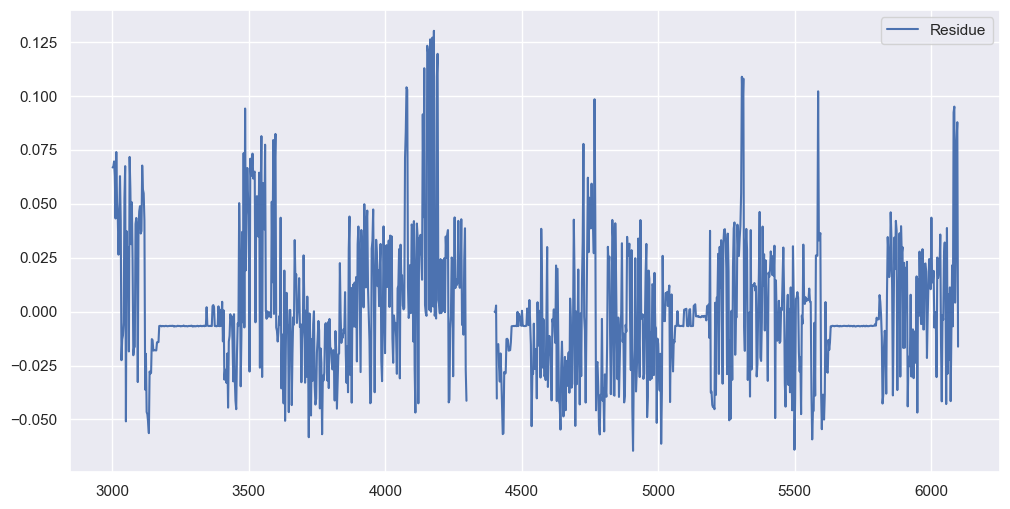

In [420]:
plt.figure(figsize=(12, 6))
plt.plot(X_validation["time"], resi_plot, label = "Residue",linestyle='-') 
plt.legend() 
plt.show()